 # Introduction

In Part I of this project, we analyzed S&P 500 data from 1980 to 2023 to identify financial crises, defined as periods starting with a 20% decline from a recent peak and ending with a 20% rise from a recent trough. Our goals were to:

- Determine if stock correlations converge to one during crises, indicating increased systematic risk.
- Investigate if CAPM betas show similar patterns of heightened non-diversifiable risk.

In Part II of the project, we also constructed an optimal portfolio using various asset classes for a risk-averse investor using:
- Mean-variance optimization
- Monte Carlo simulation
- Efficient frontier plotting

The results provided insights into market dynamics during crises and offered strategies for managing risk and optimizing returns in volatile markets.

----------------------------------

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas_datareader as pdr
import yfinance as yf
from datetime import datetime

# Data

Here, we calculate daily stock returns and save them to sp500.csv. This file includes the S&P 500 index level in the ^GSPC column. To avoid imprecise correlation and CAPM beta estimates, we can remove months with fewer than 10 returns before calculating correlations and CAPM betas.

In [44]:
sp500 = (
    pd.read_csv(
        filepath_or_buffer='sp500.csv',
        parse_dates=['Date'],
        index_col=['Date']
    )
    .rename_axis(columns='Ticker')
)

gspc = sp500[['^GSPC']]
del sp500['^GSPC']

# keep only months with at least 10 returns for each stock
sp500 = (
    sp500
    .stack()
    .loc[
        (sp500.resample('M').transform('count') >= 10).stack()
    ]
    .unstack()
)

We need Fama and French factor data to calculate CAPM betas.

In [45]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900'
    )
    [0]
    .div(100)
    .rename_axis(columns='Factor')
)

/var/folders/b0/j17_z8ks51s7txmkb033x9m80000gn/T/ipykernel_3115/3836888623.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


We calculate excess returns here to simplify our CAPM beta calculations later.

In [46]:
sp500_rf = (
    sp500
    .sub(ff['RF'], axis=0)
    .join(ff[['Mkt-RF']])
    .loc['1980':'2023']
)

# Part I : Identification of Crisis Period

The function below computes crisis periods by identifying when the S&P 500 index falls by 20% or more from a peak and then rises by 20% or more from a trough. It returns a list of tuples with the start and end dates of each crisis period.

In [47]:
df = pd.read_csv("sp500.csv", parse_dates=['Date'], index_col="Date")
GSPC = "^GSPC"  

def crisis_period(df, GSPC):
    df = df[df.index.year >= 1980]
    
    crisis_periods = []
    in_crisis = False
    crisis_start_date = None
    
    index_peak = df[GSPC].iloc[0]
    index_trough = df[GSPC].iloc[0]
    
    for date, row in df.iterrows():
        current_price = row[GSPC]
        
        if pd.isna(current_price):
            continue
        
        if not in_crisis and current_price <= index_peak * 0.8:
            in_crisis = True
            crisis_start_date = date
            index_trough = current_price
            
        elif in_crisis and current_price < index_trough:
            index_trough = current_price
            
        elif in_crisis and current_price >= index_trough * 1.2:
            crisis_periods.append((crisis_start_date.strftime('%d-%B-%Y'), date.strftime('%d-%B-%Y')))
            in_crisis = False
            index_peak = current_price
            
        elif current_price > index_peak:
            index_peak = current_price
    
    if in_crisis:
        last_date = df.index[-1]
        crisis_periods.append((crisis_start_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d')))
    
    return crisis_periods

crisis_periods = crisis_period(df, GSPC)

# Print the crisis periods
n = 58
print('=' * n)
print("Crisis Periods:")
print('-' * n)
for start, end in crisis_periods:
    print(f"Starts from {start} and ends on {end}")
print('=' * n)

Crisis Periods:
----------------------------------------------------------
Starts from 22-February-1982 and ends on 14-September-1982
Starts from 19-October-1987 and ends on 08-March-1988
Starts from 12-March-2001 and ends on 05-December-2001
Starts from 10-July-2002 and ends on 22-August-2002
Starts from 09-July-2008 and ends on 08-December-2008
Starts from 23-February-2009 and ends on 23-March-2009
Starts from 12-March-2020 and ends on 08-April-2020
Starts from 13-June-2022 and ends on 08-June-2023


In analyzing the crisis periods, we identified key market downturns from 1982 to 2023. These periods were characterized by significant economic events and market disruptions:

1. 1982 (Feb-Sep): Recession driven by high inflation and interest rates. The Latin-American debt crisis.
2. 1987 (Oct-Mar): "Black Monday" stock market crash.
3. 2001 (Mar-Dec): Dot-com bubble burst.
4. 2002 (Jul-Aug): Continued fallout from the dot-com crash and major accounting scandals.
5. 2008 (Jul-Dec): Global financial crisis triggered by the housing market collapse.
6. 2009 (Feb-Mar): Market lows during the ongoing 2008 financial crisis.
7. 2020 (Mar-Apr): Market crash due to the onset of the COVID-19 pandemic.
8. 2022-2023 (Jun-Jun): Market volatility due to inflation concerns and tightening monetary policy.

# Calculations

In [48]:
def calc_bear(df, col, down=0.2, up=0.2):
    df_copy = df.copy()
    down = 1 - down
    up = 1 + up
    
    bear = df_copy['Bear'] = False
    low = high = df_copy[col].iloc[0]
    
    for i, x in df_copy[col].items():
        if not bear and (x < down*high):
            bear = df_copy.at[i, 'Bear'] = True
            low = high = x
        elif bear and (x > up*low):
            bear = df_copy.at[i, 'Bear'] = False
            low = high = x
        else:
            df_copy.at[i, 'Bear'] = bear
            low = min(x, low)
            high = max(x, high)

    return df_copy

def resample_bear(df, freq, n):
    return df.resample(freq)['Bear'].sum().gt(n - 1).astype(bool).to_frame('Bear')

def calc_corr(df, freq):
    return df.groupby(pd.Grouper(freq=freq)).corr().stack().rename_axis(index=['Date', 'T1', 'T2']).to_frame('corr').reset_index().query('T1 < T2').set_index('Date')

def calc_beta(df, freq):
    grouped = df.groupby(pd.Grouper(freq=freq))
    top = grouped.cov()['Mkt-RF']
    bot = grouped['Mkt-RF'].var()
    return top.div(bot).rename_axis(index=['Date', 'T1']).to_frame('beta').reset_index().query('T1 != "Mkt-RF"')

# Calculate bear markets and resample them to align with the monthly and quarterly data
bear_d = gspc.pipe(calc_bear, '^GSPC')
bear_m = bear_d.pipe(resample_bear, freq='M', n=10)

# Calculate correlations
corr_m = sp500.pipe(calc_corr, freq='M').groupby('Date')['corr'].mean().rename('Monthly')

# Calculate CAPM betas
beta_m = sp500_rf.pipe(calc_beta, freq='M').groupby('Date')['beta'].mean().rename('Monthly')

# Analysis

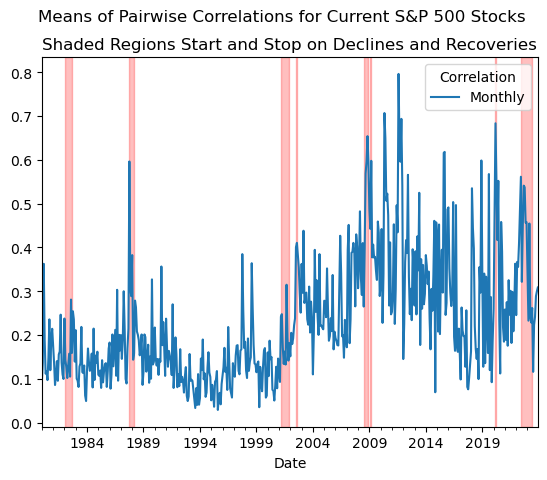

In [49]:
# Correlation Plot 

fig, ax = plt.subplots()
corr_m.plot(ax=ax)
plt.legend(title='Correlation')
for start, end in crisis_periods:
    ax.axvspan(xmin=start, xmax=end, color='red', alpha=0.25)
plt.suptitle('Means of Pairwise Correlations for Current S&P 500 Stocks')
plt.title('Shaded Regions Start and Stop on Declines and Recoveries')
plt.show()

- The spikes in correlations during the crises highlighted (such as during the 1987 market crash, the dot-com bubble burst in the early 2000s, the 2008 financial crisis, and the COVID-19 pandemic in 2020) support the notion that "correlations go to one" is directionally true during crises, though not absolute.
- The highest spikes seem to align well with the shaded crisis periods, confirming increased systematic risk during these times.

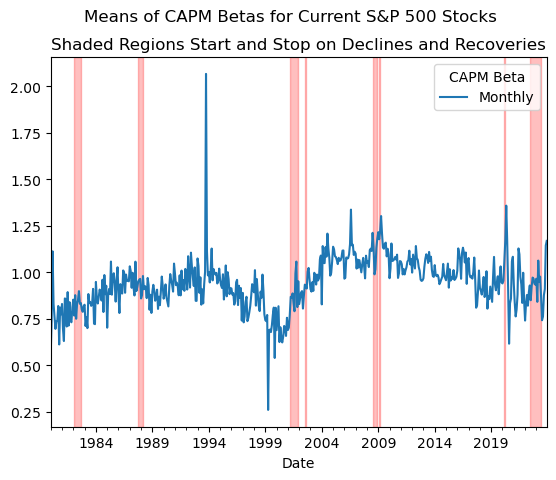

In [50]:
# Analyzing CAPM Betas

fig, ax = plt.subplots()
beta_m.plot(ax=ax)
plt.legend(title='CAPM Beta')
for start, end in crisis_periods:
    ax.axvspan(xmin=start, xmax=end, color='red', alpha=0.25)
plt.suptitle('Means of CAPM Betas for Current S&P 500 Stocks')
plt.title('Shaded Regions Start and Stop on Declines and Recoveries')
plt.show()

- General Trend: CAPM betas show more stability over time compared to correlations. They generally hover around 1, indicating that, on average, the S&P 500 stocks have a beta of 1, meaning they move in line with the market. There are some variations, but the spikes and drops are less pronounced compared to correlations.

- Crisis Periods: During crises, there are slight increases and decreases in the beta values, but they do not exhibit as dramatic changes as correlations do. This indicates that while individual stocks' betas do adjust, the changes are not as pronounced or consistent across crises as the correlations are.

# Part I : Conclusion

/Users/muskaanporwal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


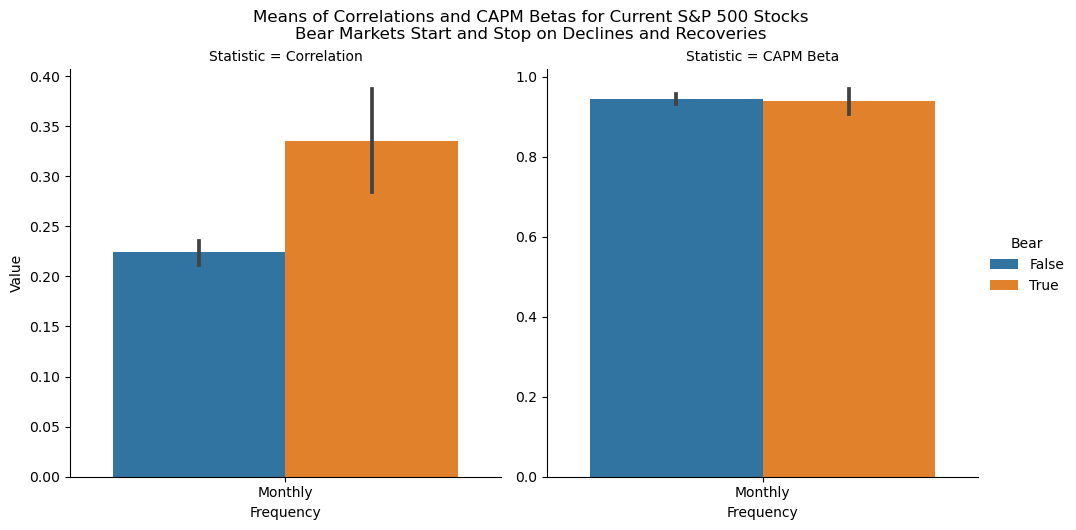

In [51]:
# Bar plots for different perspectives
df_m = bear_m.copy()
df_m['Correlation'] = corr_m
df_m['CAPM Beta'] = beta_m

df = pd.concat(objs=[df_m.dropna()], keys=['Monthly'], names=['Frequency']).reset_index().melt(id_vars=['Frequency', 'Date', 'Bear'], var_name='Statistic', value_name='Value')

sns.catplot(data=df, x='Frequency', y='Value', col='Statistic', hue='Bear', kind='bar', sharey=False)
plt.suptitle('Means of Correlations and CAPM Betas for Current S&P 500 Stocks\nBear Markets Start and Stop on Declines and Recoveries', y=1.05)
plt.show()

The analysis indicates that:

- Correlations: There is a significant increase in correlations during crisis periods. While correlations do not exactly reach 1, they move significantly higher, indicating increased systematic risk and reduced diversification benefits during market turmoil.
- CAPM Betas: There are some changes in CAPM betas during crisis periods, but they are not as pronounced as the changes in correlations. The betas remain relatively stable, suggesting that individual stock risk (relative to the market) does not fluctuate as dramatically as the co-movement of stocks.

Overall, the data supports the hypothesis that correlations tend to increase during crises, highlighting the need for investors to consider this systematic risk and potentially adjust their strategies during turbulent market periods.

# Part II : Optimum Portfolio

We calculate the descriptive statistics for all the sample asset classes that we will be using to construct an optimum portfolio for a risk averse investor

In [52]:
data = pd.read_csv('histretSP.csv', index_col=0)  
print(data.head())
print(data.describe())

       S&P 500  T-Bill    T-Bond  Baa Bond  Real Estate      Gold
Year                                                             
1928  0.438112  0.0308  0.008355  0.032196     0.014911  0.000969
1929 -0.082979  0.0316  0.042038  0.030179    -0.020568 -0.001452
1930 -0.251236  0.0455  0.045409  0.005398    -0.043000  0.000969
1931 -0.438375  0.0231 -0.025589 -0.156808    -0.081505 -0.173850
1932 -0.086424  0.0107  0.087903  0.235896    -0.104664  0.212778
         S&P 500     T-Bill     T-Bond   Baa Bond  Real Estate       Gold
count  96.000000  96.000000  96.000000  96.000000    96.000000  96.000000
mean    0.116578   0.033385   0.048587   0.069537     0.044181   0.065542
std     0.195508   0.030075   0.079517   0.077123     0.062416   0.207722
min    -0.438375   0.000327  -0.178282  -0.156808    -0.119956  -0.325986
25%    -0.011935   0.008508   0.008063   0.023922     0.009206  -0.005910
50%     0.145211   0.029350   0.032822   0.063554     0.038540   0.000969
75%     0.259666   0

----------------------------------
**Method for computing optimum portfolio**
- **Objective Function**: Defined as `negative_sharpe_ratio` to maximize the Sharpe ratio by minimizing its negative value in the optimization process.
- **Initial Weights**: Evenly distributed across all assets.
- **Constraints**: Portfolio weights are constrained to sum to 1.
- **Bounds**: Set between 0 and 1 for each weight to prevent short-selling or leveraging.
- **Monte Carlo Simulation**: Simulates various risk-return profiles through numerous random portfolios.

In [53]:
# Calculate annualized returns and covariance matrix
annual_returns = data.mean()
cov_matrix = data.cov()

# Risk-free rate (using the mean return of T-Bills as the risk-free rate)
risk_free_rate = annual_returns['T-Bill']

# Negative Sharpe Ratio for minimization
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(ret - risk_free_rate) / vol

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in annual_returns)
initial_weights = np.full(len(annual_returns), 1. / len(annual_returns))

# Optimize portfolio
result = sco.minimize(negative_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix, risk_free_rate), 
                      method='SLSQP', bounds=bounds, constraints=constraints)

# Monte Carlo simulation
n_portfolios = 100000
weights = np.random.dirichlet(np.ones(len(annual_returns)), n_portfolios)
rets = weights.dot(annual_returns)
vols = np.sqrt(np.einsum('ij,ji->i', weights.dot(cov_matrix), weights.T))
sharpes = (rets - risk_free_rate) / vols
max_idx = sharpes.argmax()

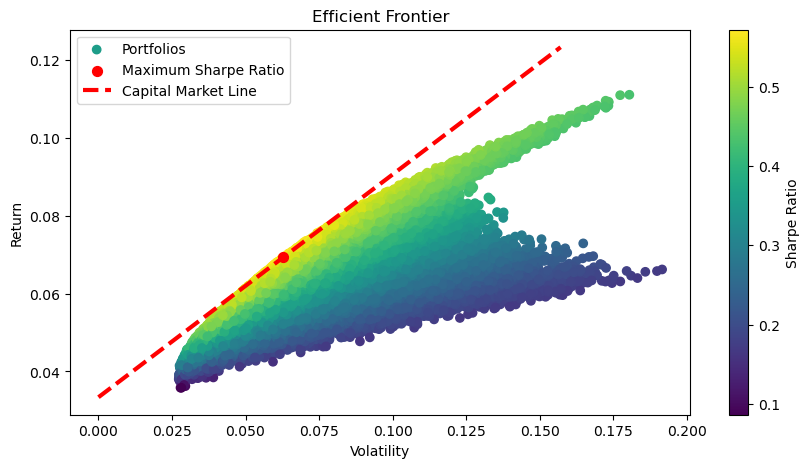

Maximum Sharpe Ratio Return: 6.935%
Volatility: 6.284%

Optimized Weights:
S&P 500        0.159146
T-Bill         0.010719
T-Bond         0.007180
Baa Bond       0.480236
Real Estate    0.269814
Gold           0.072905
dtype: float64


In [54]:
# Plot Efficient Frontier
plt.figure(figsize=(10, 5))
plt.scatter(vols, rets, c=sharpes, cmap='viridis', label='Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(vols[max_idx], rets[max_idx], c='red', s=50, label='Maximum Sharpe Ratio')
end_vol = vols[max_idx] * 2.5
end_ret = risk_free_rate + (rets[max_idx] - risk_free_rate) / vols[max_idx] * end_vol
plt.plot([0, end_vol], [risk_free_rate, end_ret], 'r--', linewidth=3, label='Capital Market Line')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()

# Output results
weights_series = pd.Series(weights[max_idx], index=data.columns)
print(f"Maximum Sharpe Ratio Return: {rets[max_idx]:.3%}")
print(f"Volatility: {vols[max_idx]:.3%}")
print("\nOptimized Weights:")
print(weights_series)

- **Efficient Frontier Visualization**:
    - The chart displays a variety of portfolios, with the efficient frontier being the upper edge of the colored region.
    - The color gradient indicates the Sharpe Ratio of each portfolio, with warmer colors (yellow) representing higher Sharpe Ratios.

- **Maximum Sharpe Ratio Portfolio**:
    - Marked by a red dot, indicating the portfolio on the efficient frontier with the highest Sharpe Ratio, often referred to as the Tangency Portfolio.
    - This portfolio has an expected return of 6.935% with a volatility of 6.284%.

- **Capital Market Line (CML)**:
    - Represented by the dashed red line, it shows the risk-return trade-off of efficient portfolios when combined with the risk-free asset.
    - The slope of the CML gives the Sharpe Ratio of the market portfolio.

- **Optimized Weights**:
    - The weights for the portfolio with the maximum Sharpe Ratio are displayed, indicating how much of each asset class should be included for the optimal risk-adjusted return.
    - The allocation is diversified across various asset classes, with a significant weight in the Baa Bond and Real Estate, suggesting a preference for assets with stable returns.

# Sharpe Ratio Analysis

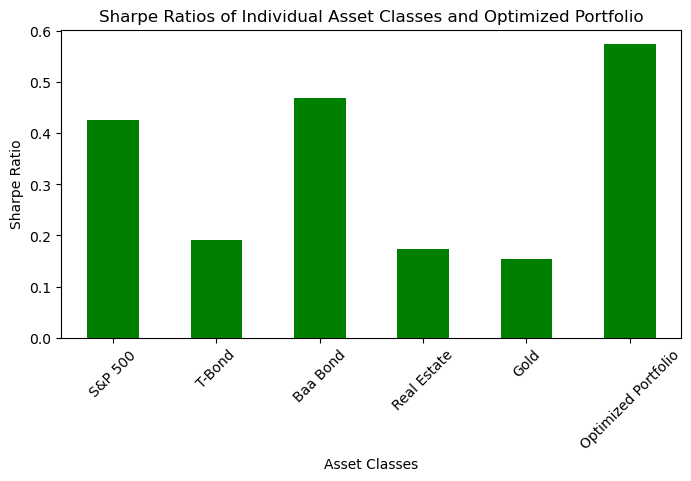

In [94]:
# Convert annual_returns and volatility to Series to drop T-Bill (since we used T-Bill as risk free rate)
annual_returns_series = pd.Series(annual_returns, index=data.columns)
volatility_series = pd.Series(volatility, index=data.columns)

# Exclude T-Bill from calculations
annual_returns_ex_tbill = annual_returns_series.drop('T-Bill')
volatility_ex_tbill = volatility_series.drop('T-Bill')
cov_matrix_ex_tbill = cov_matrix.drop(index='T-Bill', columns='T-Bill')

# Calculate Sharpe Ratios for individual asset classes (excluding T-Bill)
sharpe_ratios = (annual_returns_ex_tbill - risk_free_rate) / volatility_ex_tbill

# Optimized portfolio weights
opt_weights = result.x
opt_return = np.dot(opt_weights, annual_returns)
opt_volatility = np.sqrt(np.dot(opt_weights.T, np.dot(cov_matrix, opt_weights)))
opt_sharpe_ratio = (opt_return - risk_free_rate) / opt_volatility
sharpe_ratios['Optimized Portfolio'] = opt_sharpe_ratio

# Plot Sharpe Ratios
plt.figure(figsize=(8, 4))
sharpe_ratios.plot(kind='bar', color='green')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.xlabel('Asset Classes')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios of Individual Asset Classes and Optimized Portfolio')
plt.xticks(rotation=45)
plt.show()

The optimized portfolio constructed by maximizing the Sharpe ratio achieves a balance between return and risk, providing an efficient investment strategy for risk-averse investors. This portfolio's higher Sharpe ratio indicates better risk-adjusted returns compared to individual asset classes.